In [ ]:
# default_exp funcs.merfish_eval2

In [ ]:
%load_ext autoreload
%autoreload 2

# MERFISH routines

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

from numba import njit
from scipy.spatial import cKDTree
from decode_fish.funcs.evaluation import matching

import io, requests
from sklearn.neighbors import NearestNeighbors
from starfish import data
import torch.tensor as T
import pprint

In [ ]:
# export
def get_benchmark(magnitude_threshold=10**0.75*4):

    bench = pd.read_csv(
        io.BytesIO(requests.get('https://d2nhj9g34unfro.cloudfront.net/MERFISH/benchmark_results.csv').content),
        dtype={'barcode': object})

    #See Fig. S4 https://www.pnas.org/content/113/39/11046

    bench_df = bench.copy()
    bench_df = bench_df[bench_df['total_magnitude']>magnitude_threshold]
    bench_df = bench_df[bench_df['area']>3]

    print(len(bench_df))

    experiment = data.MERFISH(use_test_data=True)
    code_ref = experiment.codebook.data.reshape([140,-1], order='F')
    targets = experiment.codebook.indexes['target']
    
    return bench_df, code_ref, targets

In [ ]:
bench_df, code_ref, targets = get_benchmark()

13832


In [ ]:
pred_df = pd.read_csv('../data/results/MERFISH/exp_ci_1.csv')
pred_df = pd.read_csv('../data/results/MERFISH/exp_ci14_ct04.csv')

pred_df = exclude_borders(pred_df, border_size_zyx=[0,4000,4000], img_size=[2048*100,2048*100,2048*100])
pred_df.loc[:,'comb_sig'] = 100*(pred_df.loc[:,'comb_sig']-1)
len(pred_df)

46096

In [ ]:
# from decode_fish.funcs.routines import filt_perc
# pred_df = filt_perc(pred_df, 50)
# len(pred_df)

100%|███████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 252.18it/s]


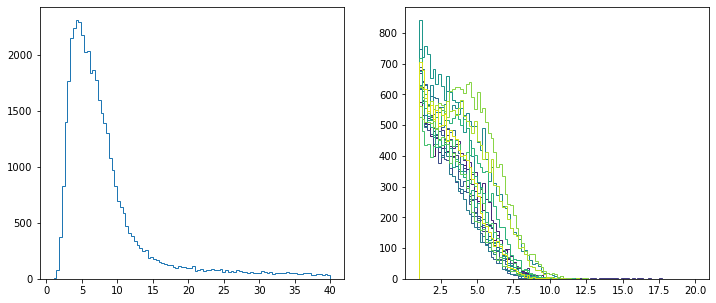

In [ ]:
import seaborn as sns
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(pred_df['comb_sig'], histtype='step', bins=np.linspace(1,40,101))

plt.subplot(122)
for i in tqdm(range(0,16)):
    color='red' if i<8 else 'green'
    plt.hist(pred_df[f'int_{i}'], histtype='step', color=cmap[i], bins=np.linspace(1,20,101))

In [ ]:
#export
@njit
def index(array, item):
    for idx, val in np.ndenumerate(array):
        if val == item:
            return idx[0]
    return None

def get_bin_code(frame_idx, n_imgs=16):
    code = np.zeros(n_imgs, dtype='int8')
    code[frame_idx] = 1
    return code

def norm_features(code, norm_order = 2):
    
    norm = np.linalg.norm(code, ord=norm_order, axis=1)
    code = code / norm[:, None]

    return code

def approximate_nearest_code(ref_code, pred_code, targets):
    
    nn = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='euclidean').fit(ref_code)
    metric_output, indices = nn.kneighbors(pred_code)
    gene_ids = np.ravel(targets.values[indices])

    return np.ravel(metric_output), gene_ids, indices

def vcorrcoef(X,y):
    Xm = np.reshape(np.mean(X,axis=1),(X.shape[0],1))
    ym = np.mean(y)
    r_num = np.sum((X-Xm)*(y-ym),axis=1)
    r_den = np.sqrt(np.sum((X-Xm)**2,axis=1)*np.sum((y-ym)**2))
    r = r_num/r_den
    return r

def bce_code(ref_code, pred_code):
    
    bce = torch.nn.BCELoss(reduction='none')
    return bce(T(ref_code, dtype=torch.float32), T(pred_code[None].repeat(len(ref_code),0), dtype=torch.float32)).mean(-1)
        

In [ ]:
int_keys = [f'int_{i}' for i in range(16)]
int_pred = pred_df[int_keys].values

In [ ]:
# metric_output, gene_ids, indices = approximate_nearest_code(norm_features(code_ref), norm_features(int_pred), targets)
# res_df_nn = pred_df.copy()
# res_df_nn['code_err'] = metric_output
# res_df_nn['code_inds'] = indices
# res_df_nn['gene'] = gene_ids

In [ ]:
# export
def match_bench(pred_df, bench_df):

    bench_match = bench_df.copy()
    bench_match.loc[:,'frame_idx'] = 0
    bench_match.loc[:,'loc_idx'] = np.arange(len(bench_match))
    bench_match.loc[:,'int'] = bench_match['total_magnitude']
    bench_match.loc[:,'z'] = 50/100
    bench_match = px_to_nm(bench_match)

    pred_df.loc[:,'frame_idx'] = 0

    _,_,shift = matching(bench_match, pred_df, tolerance=250, print_res=False)
    print(shift)
    bench_match = shift_df(bench_match, shift=-np.array(shift))

    _,_,shift = matching(bench_match, pred_df, tolerance=250, print_res=False)

    bench_match = shift_df(bench_match, shift=-np.array(shift))
    _,matches,shift = matching(bench_match, pred_df, tolerance=250, print_res=True)
    
    return matches, bench_match

In [ ]:
res_df_corr = pred_df.copy()

code_err = []
code_ind = []

for i in tqdm(range(len(int_pred))):

    code_errors = 1-vcorrcoef(code_ref, int_pred[i])
#     code_errors = bce_code(code_ref, int_pred[i])
    min_ind = np.argmin(code_errors)
    code_err.append(code_errors[min_ind])
    code_ind.append(min_ind)

res_df_corr['code_err'] = code_err
res_df_corr['code_inds'] = code_ind
res_df_corr['gene'] = targets[code_ind]

100%|████████████████████████████████████████████████████| 46096/46096 [00:04<00:00, 9856.46it/s]


In [ ]:
matches, bench_match = match_bench(res_df_corr, bench_df)

[76.15893616583857, 76.5561613414426, 0.0]
Recall: 0.892
Precision: 0.261
Jaccard: 25.302
RMSE_vol: 89.007
Eff_3d: 13.050
FN: 1493.0 FP: 34934.0
Num. matches: 12339.000
Shift: 3.71,3.89,0.00


In [ ]:
matches, bench_match = match_bench(res_df_corr, bench_df)

[77.27766879917007, 77.49443321518113, 0.0]
Recall: 0.889
Precision: 0.267
Jaccard: 25.799
RMSE_vol: 89.380
Eff_3d: 13.380
FN: 1542.0 FP: 33806.0
Num. matches: 12290.000
Shift: 3.86,4.17,0.00


In [ ]:
# matches, bench_match = match_bench(res_df, bench_df)

In [ ]:
# res_df = res_df_corr.sort_values('corr_pred', ascending=True)
# res_sub = res_df[:40000]

In [ ]:
res_df = res_df_corr.sort_values('code_err', ascending=True)
res_sub = res_df[:17500]

In [ ]:
bench_counts = DF(data=None, index=targets)
bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
bench_counts = bench_counts.fillna(0)

fps = res_sub.loc[~res_sub['loc_idx'].isin(matches['pred_idx'])]
fns = bench_match.loc[~bench_match['loc_idx'].isin(matches['tar_idx'])]

bench_counts['Res_fp'] = fps.groupby('gene')['gene'].count()
bench_counts['Res_fns'] = fns.groupby('gene')['gene'].count()
bench_counts=bench_counts.fillna(0)

In [ ]:
#export
def plot_gene_numbers(bench_counts, res_counts, title='', log=True, corr=True):
    
    if corr:
        r = np.corrcoef(bench_counts, res_counts)[0, 1]   
        r = np.round(r, decimals=3)
    else:
        r = np.sum(res_counts)
    x_lim = np.max([bench_counts.max(), res_counts.max()])
    x = np.linspace(0, x_lim)
    
    plt.scatter(bench_counts, res_counts, 50, zorder=2)
    plt.plot(x, x, '-k', zorder=1)

    plt.xlabel('Gene copy number Benchmark')
    plt.ylabel('Gene copy number DECODE')
    if log:
        plt.xscale('log')
        plt.yscale('log')
    plt.title(f'{title} r = {r}');

13832 17500


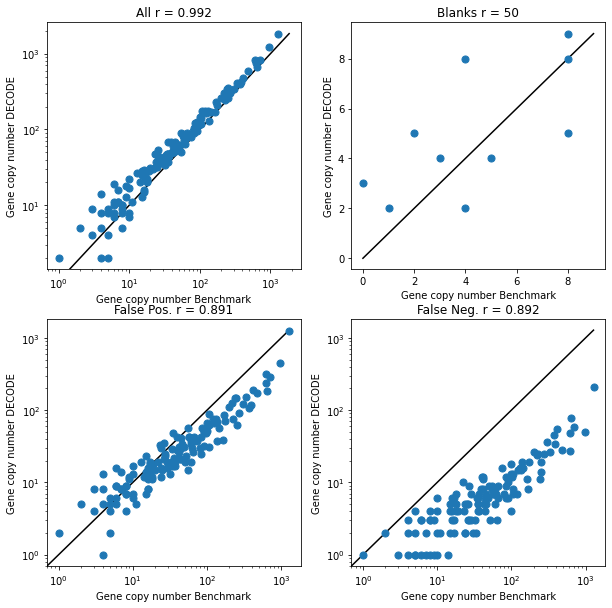

In [ ]:
print(len(bench_df), len(res_sub))

plt.figure(figsize=(10,10))
plt.subplot(221)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_all'].values, 'All', log=True)

binds = []
for i,g in enumerate(targets):
    if 'Blank' in g:
        binds.append(g)
        
plt.subplot(222)
plot_gene_numbers(bench_counts.loc[binds, 'Bench_all'].values, bench_counts.loc[binds,'Res_all'].values, 'Blanks', log=False, corr=False)

plt.subplot(223)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fp'].values, 'False Pos.', log=True)

plt.subplot(224)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fns'].values, 'False Neg.', log=True)

13832 17500


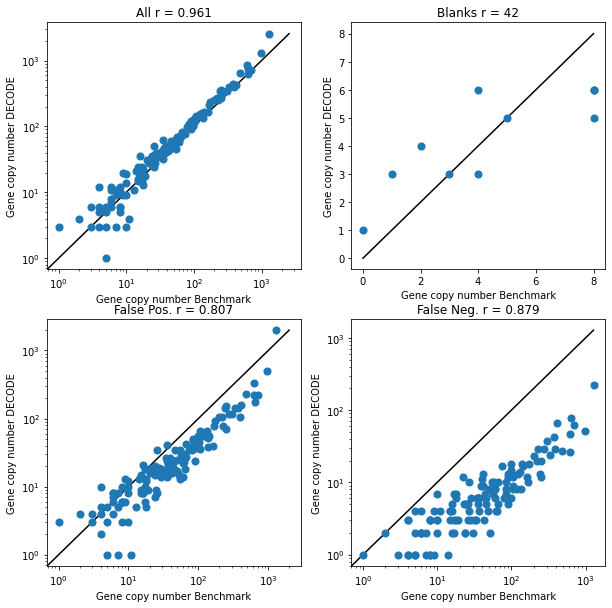

In [ ]:
print(len(bench_df), len(res_sub))

plt.figure(figsize=(10,10))
plt.subplot(221)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_all'].values, 'All', log=True)

binds = []
for i,g in enumerate(targets):
    if 'Blank' in g:
        binds.append(g)
        
plt.subplot(222)
plot_gene_numbers(bench_counts.loc[binds, 'Bench_all'].values, bench_counts.loc[binds,'Res_all'].values, 'Blanks', log=False, corr=False)

plt.subplot(223)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fp'].values, 'False Pos.', log=True)

plt.subplot(224)
plot_gene_numbers(bench_counts['Bench_all'].values, bench_counts['Res_fns'].values, 'False Neg.', log=True)

In [ ]:
def make_roc(df, var='code_err', ascending=True):
    
    x = np.arange(1000,len(df),100)
    df = df.sort_values(var, ascending=ascending)
    n_blanks = []
    for i in x:
        n_blanks.append((df[:int(i)]['gene'].str.contains('Blank')).sum())
        
    return x, n_blanks

In [ ]:
from decode_fish.funcs.visualization import *
par_dict = {'res_df_nn':[res_df_nn, 'code_err', True],
            'res_df_corr':[res_df_corr, 'code_err', True],
            'res_df_bce':[res_df_bce, 'code_err', True],
            'bench_df':[bench_df, 'total_magnitude', False]}

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]

In [ ]:
from decode_fish.funcs.visualization import *
par_dict = {'res_df_ce':[res_df, 'code_err', True],
            'res_df_cs':[res_df, 'comb_sig', True],
            'res_df_cp':[res_df, 'corr_pred', False],
            'bench_df':[bench_df, 'total_magnitude', False]}

roc_dict = {}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]

(0.0, 22000.0)

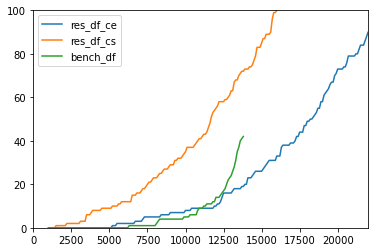

In [ ]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 22000)

(0.0, 22000.0)

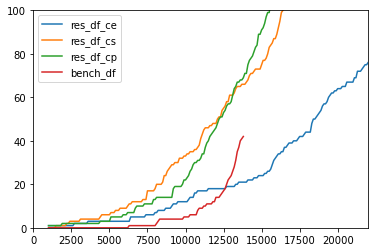

In [ ]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 22000)

In [ ]:
from decode_fish.funcs.visualization import *
roc_dict = {}

for i in tqdm(range(6)):
    res_df[f'k_{i}'] = (1-i*0.2)*res_df['code_err'] + i*0.2*res_df['comb_sig']/100
#     res_df[f'k_{i}'] = (1-i*0.2)*res_df['code_err'] + i*0.2*(1-res_df['corr_pred'])
    par_dict = {f'k_{i}':[res_df, f'k_{i}', True]}

    for k in par_dict:
        x, y = make_roc(*par_dict[k])
        roc_dict[k] = [x, y]
        
par_dict = {'bench_df':[bench_df, 'total_magnitude', False]}
for k in par_dict:
    x, y = make_roc(*par_dict[k])
    roc_dict[k] = [x, y]    

100%|██████████████████████████████████████████████████████████████| 6/6 [00:20<00:00,  3.47s/it]


(0.0, 22000.0)

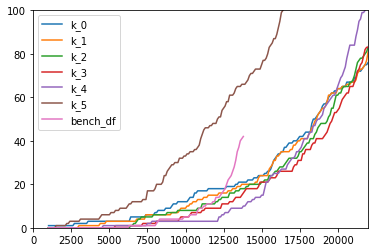

In [ ]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 22000)

(0.0, 22000.0)

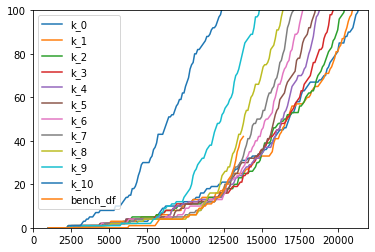

In [ ]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 100)
plt.xlim(0, 22000)

(0.0, 20000.0)

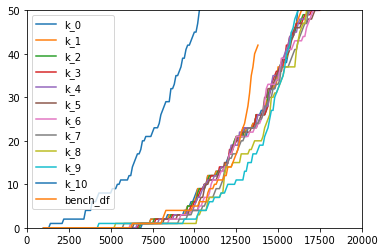

In [ ]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 50)
plt.xlim(0, 20000)

(0.0, 20000.0)

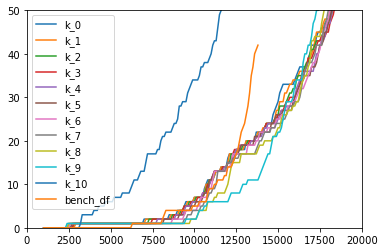

In [ ]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 50)
plt.xlim(0, 20000)

(0.0, 20000.0)

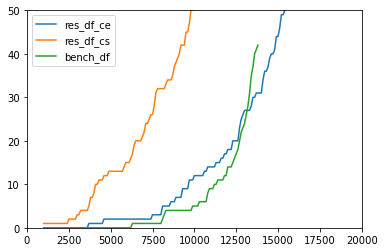

In [ ]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 50)
plt.xlim(0, 20000)

(0.0, 24000.0)

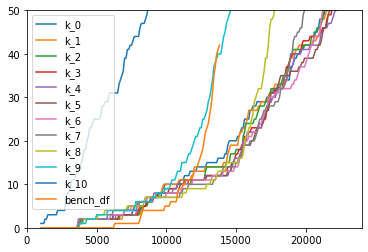

In [ ]:
for k in roc_dict:
    x, y = roc_dict[k]
    plt.plot(x, y, label=k)
    
plt.legend()
plt.ylim(0, 50)
plt.xlim(0, 24000)

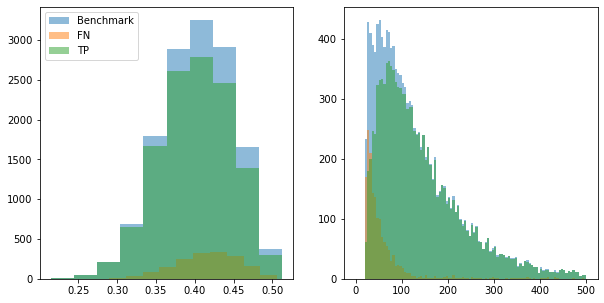

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
_ = plt.hist(bench_match['av_distance'], density=False, alpha=0.5, label='Benchmark')
_ = plt.hist(bench_match['av_distance'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5, label='FN')
_ = plt.hist(bench_match['av_distance'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, alpha=0.5, label='TP')
plt.legend()

plt.subplot(122)
_ = plt.hist(bench_match['total_magnitude'], density=False, bins=np.linspace(0,500,101), alpha=0.5, label='Benchmark')
_ = plt.hist(bench_match['total_magnitude'][~bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5, label='FN')
_ = plt.hist(bench_match['total_magnitude'][bench_match['loc_idx'].isin(matches['tar_idx'])], density=False, bins=np.linspace(0,500,101), alpha=0.5, label='TP')

In [ ]:
image_paths = sorted(glob.glob('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish/*.tiff'))

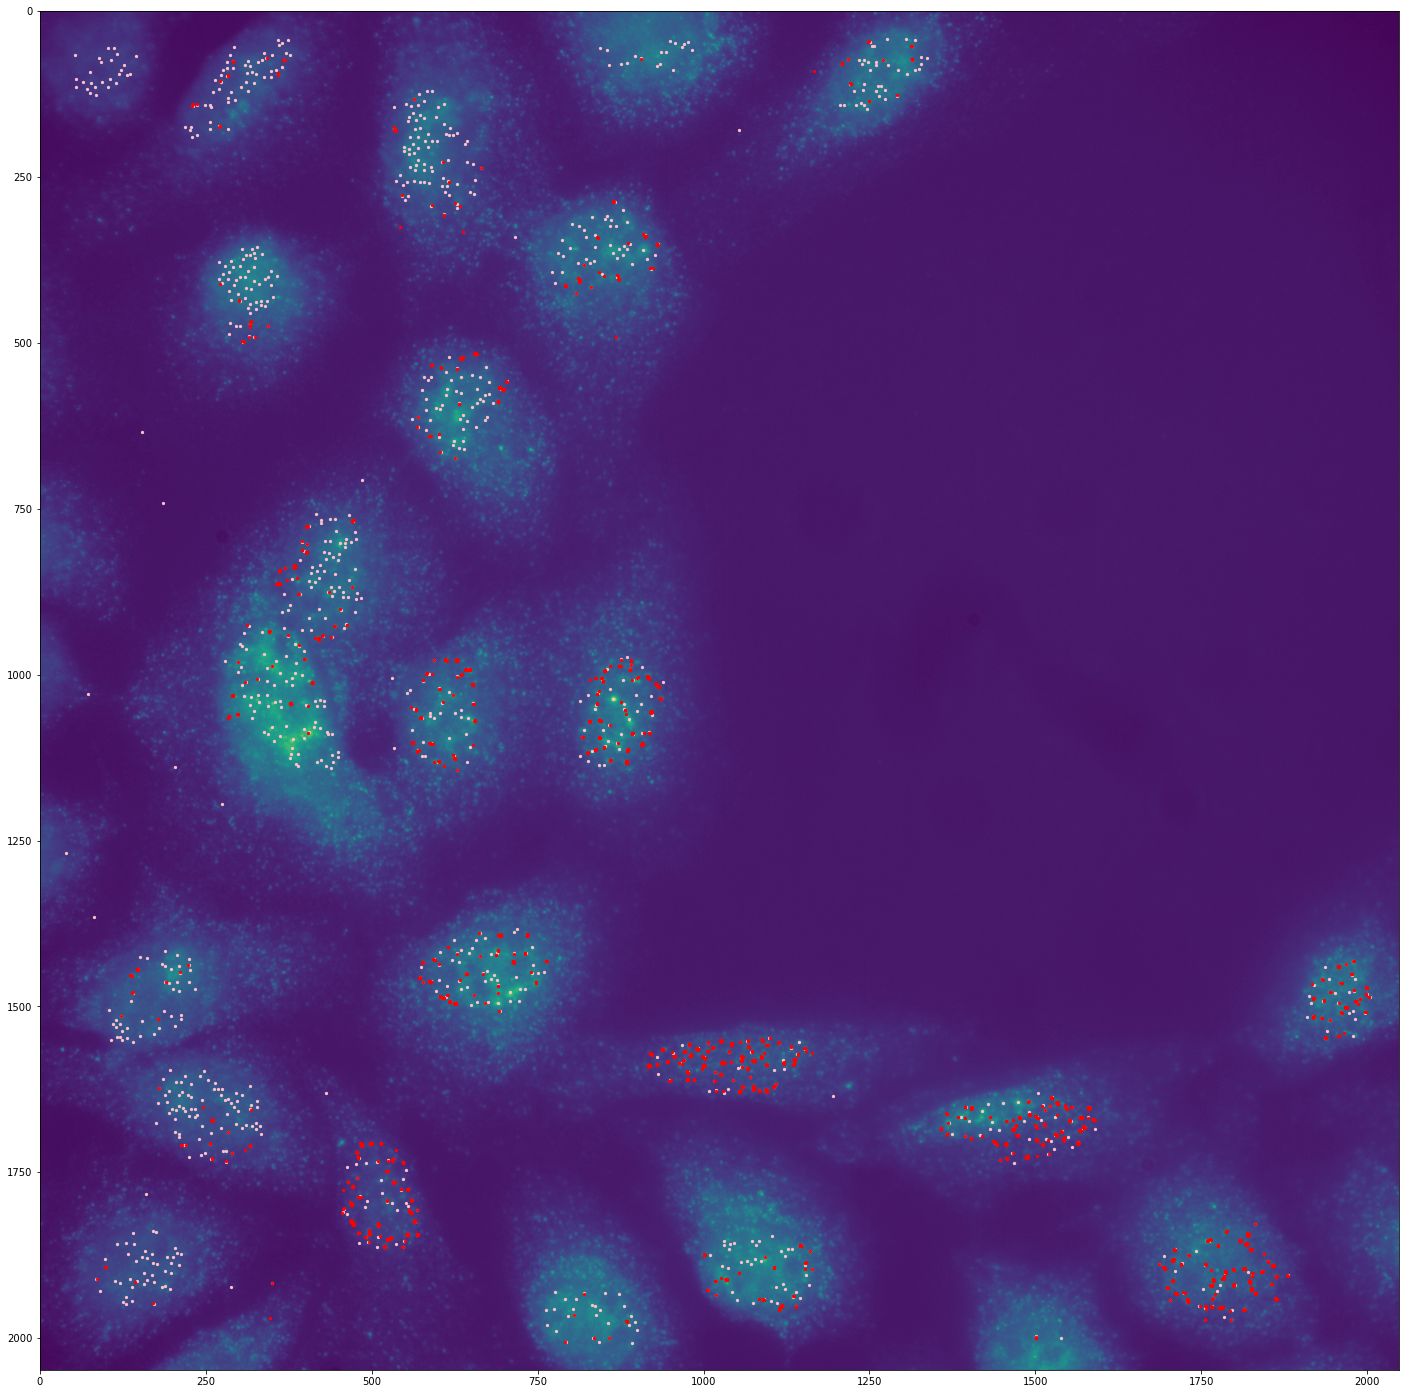

In [ ]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds_px = nm_to_px(res_sub)[res_sub['gene']=='MALAT1']
bench_px = nm_to_px(bench_match)[bench_match['gene']=='MALAT1']
plt.figure(figsize=(25,25))
plt.imshow(img[0,0])

plt.scatter(bench_px['x'],bench_px['y'], color='pink', s=5)
plt.scatter(preds_px['x'],preds_px['y'], color='red', s=5)

In [ ]:
img_stack = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//datasets/CodFish/MERFISH/starfish_scaled/img_stack.tiff')[:,0]

In [ ]:
def extract_roi(beads: torch.Tensor, coordinates: torch.Tensor, size_xy: int=10, size_z: int=10):
    res = []
    tot_size = torch.Size([1, 16, size_xy*2+1, size_xy*2+1])
    
    x, y, z = coordinates
    crop = np.s_[:,:, int(y-size_xy): int(y+size_xy+1), int(x-size_xy): int(x+size_xy+1)]
    single_bead = beads[crop]
        
    return single_bead, crop

7644


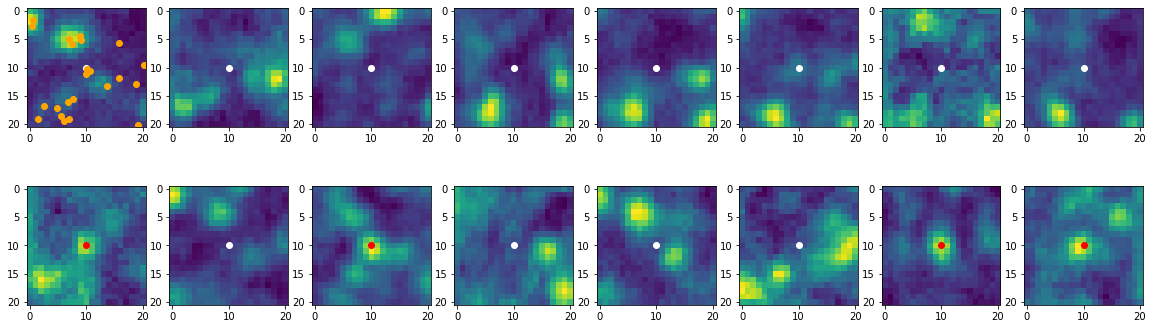

In [ ]:
# Random predictions 
sub = res_sub
# Random blank 
# sub = res_sub[res_sub['gene'].str.contains('Blank')]

ind = np.random.randint(0, len(sub))
print(ind)

b_loc = nm_to_px(sub.iloc[ind])
vol, crop = extract_roi(img_stack[None], torch.IntTensor(np.array(b_loc.loc[['x','y','z']].values, dtype='float32')), 10, 8)

crop = crop_df(nm_to_px(pred_df), crop)

plt.figure(figsize=(20,6))
for i in range(16):
    plt.subplot(2,8,i+1)
    plt.imshow(vol[0,i])
    color = 'red' if code_ref[list(targets.values).index(b_loc['gene'])][i] else 'white'
    plt.scatter([10],[10], color=color)
    
    cdf = crop[crop['frame_idx']==i]
    plt.scatter(cdf['x'],cdf['y'],color='orange')

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted hyper.ipynb.
Converted index.ipynb.
